In [1]:
from utils import reduce_mem_usage

import pandas as pd
import numpy as np
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.feature_extraction import extract_features, MinimalFCParameters
from tsfresh.transformers.feature_augmenter import FeatureAugmenter

In [2]:
# Constant definitions

def load(filename: str) -> pd.DataFrame:
    return pd.read_csv(f"Dataset/{filename}")

In [3]:
# Load data.

sales_df    = load("sales_train_validation.csv")
prices_df   = load("sell_prices.csv")
calendar_df = load("calendar.csv")

In [4]:
# Add ID column to calendar df.

calendar_df["calendar_id"]  = "d_" + (calendar_df.index + 1).astype(str)

In [5]:
# Keep only two ID_VARS: one for the item and one for the store.
# These two variables contain all the info of the product description.

ID_VARS = ["item_id", "store_id"]
to_drop = ["dept_id", "cat_id", "state_id"]
sales_df.drop(to_drop, axis=1, inplace=True)

In [6]:
melt_df = sales_df.melt(ID_VARS, var_name="d", value_name="target")
melt_df = reduce_mem_usage(melt_df)

Mem. usage decreased to 1446.26 Mb (18.7% reduction)


In [7]:
# Only forecast top `n` items at the aggregated level.

agg_df = (
    melt_df
    .groupby(["item_id", "d"], as_index=False).sum({"target": "sum"})
    .merge(calendar_df, how="inner", left_on="d", right_on="calendar_id").drop("calendar_id", axis=1)
    .sort_values(["item_id", "date"])
    .reset_index(drop=True)[["item_id", "date", "target"]]
)

n         = 100
top_items = agg_df.groupby("item_id").agg({"target": "sum"})["target"].nlargest(n).index.tolist()


# `input_timeseries_container` contains the timeseries used to train.
input_timeseries_container = agg_df.loc[agg_df["item_id"].isin(top_items)].reset_index(drop=True)

In [9]:
top_items[:10]

['FOODS_3_090',
 'FOODS_3_586',
 'FOODS_3_252',
 'FOODS_3_555',
 'FOODS_3_714',
 'FOODS_3_587',
 'FOODS_3_694',
 'FOODS_3_226',
 'FOODS_3_202',
 'FOODS_3_723']

In [10]:
input_timeseries_container["shifted_target"] = input_timeseries_container.groupby("item_id")["target"].shift(-1)

# Roll time series

In [11]:
MAX_SEQUENCE_LENGTH = 30
MIN_SEQUENCE_LENGTH = 10

In [12]:
# Rolling window.

rolled_timeseries_container = roll_time_series(
    input_timeseries_container, 
    column_id="item_id", 
    column_sort="date", 
    max_timeshift=MAX_SEQUENCE_LENGTH, 
    min_timeshift=MIN_SEQUENCE_LENGTH, 
    n_jobs=4
)

Rolling: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


In [13]:
rolled_timeseries_container

,item_id,date,target,shifted_target,id
0,FOODS_1_004,2011-01-29,0,0.0,"(FOODS_1_004, 2011-02-08)"
1,FOODS_1_004,2011-01-30,0,0.0,"(FOODS_1_004, 2011-02-08)"
2,FOODS_1_004,2011-01-31,0,0.0,"(FOODS_1_004, 2011-02-08)"
3,FOODS_1_004,2011-02-01,0,0.0,"(FOODS_1_004, 2011-02-08)"
4,FOODS_1_004,2011-02-02,0,0.0,"(FOODS_1_004, 2011-02-08)"
...,...,...,...,...,...
5580695,HOUSEHOLD_1_521,2016-04-20,48,42.0,"(HOUSEHOLD_1_521, 2016-04-24)"
5580696,HOUSEHOLD_1_521,2016-04-21,42,53.0,"(HOUSEHOLD_1_521, 2016-04-24)"
5580697,HOUSEHOLD_1_521,2016-04-22,53,69.0,"(HOUSEHOLD_1_521, 2016-04-24)"
5580698,HOUSEHOLD_1_521,2016-04-23,69,78.0,"(HOUSEHOLD_1_521, 2016-04-24)"


# GroupsRegressor

In [11]:
from sklearn.base import clone

class GroupsRegressor:
    def __init__(self, regressor, column_id, column_sort):
        self.regressor = regressor
        self.column_id = column_id
        self.column_sort = column_sort

    def fit(self, X: pd.DataFrame, y: pd.DataFrame):
        ids_to_fit = list(X.groupby(self.column_id).groups)
        pk = [self.column_id, self.column_sort]
        X = X.sort_values(pk).set_index(pk)
        y = y.sort_values(pk).set_index(pk)
        
        self.regressors_dict_ = {
            name: clone(self.regressor).fit(X.loc[name], y.loc[name].values.flatten())
            for name in ids_to_fit
        }

        return self

    def get_fitted_regressor(self, id_):
        return self.regressors_dict_.get(id_)

    def predict(self, X: pd.DataFrame):
        ids_to_predict = list(X.groupby(self.column_id).groups)
        pk = [self.column_id, self.column_sort]
        X = X.sort_values(pk).set_index(pk)

        return {
            id_: self.get_fitted_regressor(id_).predict(X.loc[id_])
            for id_ in ids_to_predict
            if id_ in self.regressors_dict_
        }

# IndexResetter

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class IndexResetter(BaseEstimator, TransformerMixin):
    def __init__(self, names=None, drop=True):
        self.names = names
        self.drop = drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.names is not None:
            X.index.set_names(self.names, inplace=True)
        
        return X.reset_index(drop=self.drop)

# Pipeline

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor

In [14]:
# 1. Extract features.
feature_extractor = FeatureAugmenter(
    column_id="id", column_sort="date", 
    column_value="target", default_fc_parameters=MinimalFCParameters())

# 2. Reset index.
index_resetter = IndexResetter(names=["item_id", "date"], drop=False)

# 3. Fit multiple groups.
regressor = GroupsRegressor(
    HistGradientBoostingRegressor(), column_id="item_id", 
    column_sort="date"
)

# Make pipeline.
pipeline = Pipeline([
    ("feature_extractor", feature_extractor),
    ("index_resetter", index_resetter),
    ("regressor", regressor)
])

In [16]:
rolled_timeseries_container

,item_id,date,target,shifted_target,id
0,FOODS_1_004,2011-01-29,0,0.0,"(FOODS_1_004, 2011-02-08)"
1,FOODS_1_004,2011-01-30,0,0.0,"(FOODS_1_004, 2011-02-08)"
2,FOODS_1_004,2011-01-31,0,0.0,"(FOODS_1_004, 2011-02-08)"
3,FOODS_1_004,2011-02-01,0,0.0,"(FOODS_1_004, 2011-02-08)"
4,FOODS_1_004,2011-02-02,0,0.0,"(FOODS_1_004, 2011-02-08)"
...,...,...,...,...,...
5580695,HOUSEHOLD_1_521,2016-04-20,48,42.0,"(HOUSEHOLD_1_521, 2016-04-24)"
5580696,HOUSEHOLD_1_521,2016-04-21,42,53.0,"(HOUSEHOLD_1_521, 2016-04-24)"
5580697,HOUSEHOLD_1_521,2016-04-22,53,69.0,"(HOUSEHOLD_1_521, 2016-04-24)"
5580698,HOUSEHOLD_1_521,2016-04-23,69,78.0,"(HOUSEHOLD_1_521, 2016-04-24)"


In [21]:
rolled_timeseries_container.loc[rolled_timeseries_container["item_id"] == "FOODS_1_004"].groupby("id").last(skipna=False)

,item_id,date,target,shifted_target
id,,,,
"(FOODS_1_004, 2011-02-08)",FOODS_1_004,2011-02-08,0,0.0
"(FOODS_1_004, 2011-02-09)",FOODS_1_004,2011-02-09,0,0.0
"(FOODS_1_004, 2011-02-10)",FOODS_1_004,2011-02-10,0,0.0
"(FOODS_1_004, 2011-02-11)",FOODS_1_004,2011-02-11,0,0.0
"(FOODS_1_004, 2011-02-12)",FOODS_1_004,2011-02-12,0,0.0
...,...,...,...,...
"(FOODS_1_004, 2016-04-20)",FOODS_1_004,2016-04-20,0,0.0
"(FOODS_1_004, 2016-04-21)",FOODS_1_004,2016-04-21,0,0.0
"(FOODS_1_004, 2016-04-22)",FOODS_1_004,2016-04-22,0,0.0


In [18]:
# Fit pipeline

X = pd.DataFrame(index=pd.MultiIndex.from_tuples(rolled_timeseries_container.id.unique()))
pipeline.set_params(feature_extractor__timeseries_container=rolled_timeseries_container)
pipeline.fit(X, y)

Feature Extraction: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:37<00:00,  1.50s/it]


ValueError: Found input variables with inconsistent numbers of samples: [1903, 1912]

# Predict

In [14]:
def autoregressive_predict(
    predictor, 
    initial_sequence, 
    extractor, 
    column_id,
    column_output, 
    column_sort, 
    horizon
):

    sequence = initial_sequence.sort_values(column_sort)

    for h in horizon:

        extractor.set_timeseries_container(sequence)
        X = pd.DataFrame(index=sequence[column_id].unique())  # Empty dataframe.
        X = extractor.transform(X)
        output = predictor.predict(X)

        # Retrieve last row and update it with output value and current timestamp.
        last = sequence.tail(1).copy()
        last.loc[:, column_output] = output
        last.loc[:, column_sort] = h

        # Auto-increment index by 1.
        last.index += 1

        # Update sequence.
        sequence = pd.concat([sequence, last]).tail(-1)

    return sequence

In [16]:
# Predict for multiple `item_id`.

import random

all_predictions = []

extractor = FeatureAugmenter(
    column_id="item_id", 
    column_sort="date", 
    column_value="target",
    default_fc_parameters=MinimalFCParameters(),
    disable_progressbar=True
)

ids_to_predict = random.sample(top_items, 10)

for item_id in ids_to_predict:

    if item_id not in regressors_dict:
        continue

    initial_sequence = (
        input_timeseries_container
            .set_index("item_id")
            .loc[item_id]
            .tail(MAX_SEQUENCE_LENGTH)
            .reset_index()
            .drop("target__shifted", axis=1)
    )
    
    initial_sequence["target"] = initial_sequence["target"].astype(float)
    predictor = regressors_dict[item_id]
    train_end = initial_sequence["date"].max()
    forecast_horizon = pd.date_range(train_end, periods=15, inclusive="right", freq="D").astype(str)

    item_id_prediction = autoregressive_predict(
        predictor, initial_sequence, extractor, column_id="item_id", 
        column_output="target", column_sort="date", horizon=forecast_horizon
    )

    all_predictions.append(item_id_prediction)

all_predictions_container = pd.concat(all_predictions)

In [17]:
input_and_output_container = pd.concat(
    [
        all_predictions_container, 
        input_timeseries_container.loc[input_timeseries_container["item_id"].isin(ids_to_predict)].drop("target__shifted", axis=1)
    ]
).drop_duplicates(["item_id", "date"]).sort_values(["item_id", "date"]).reset_index(drop=True)

# Plot

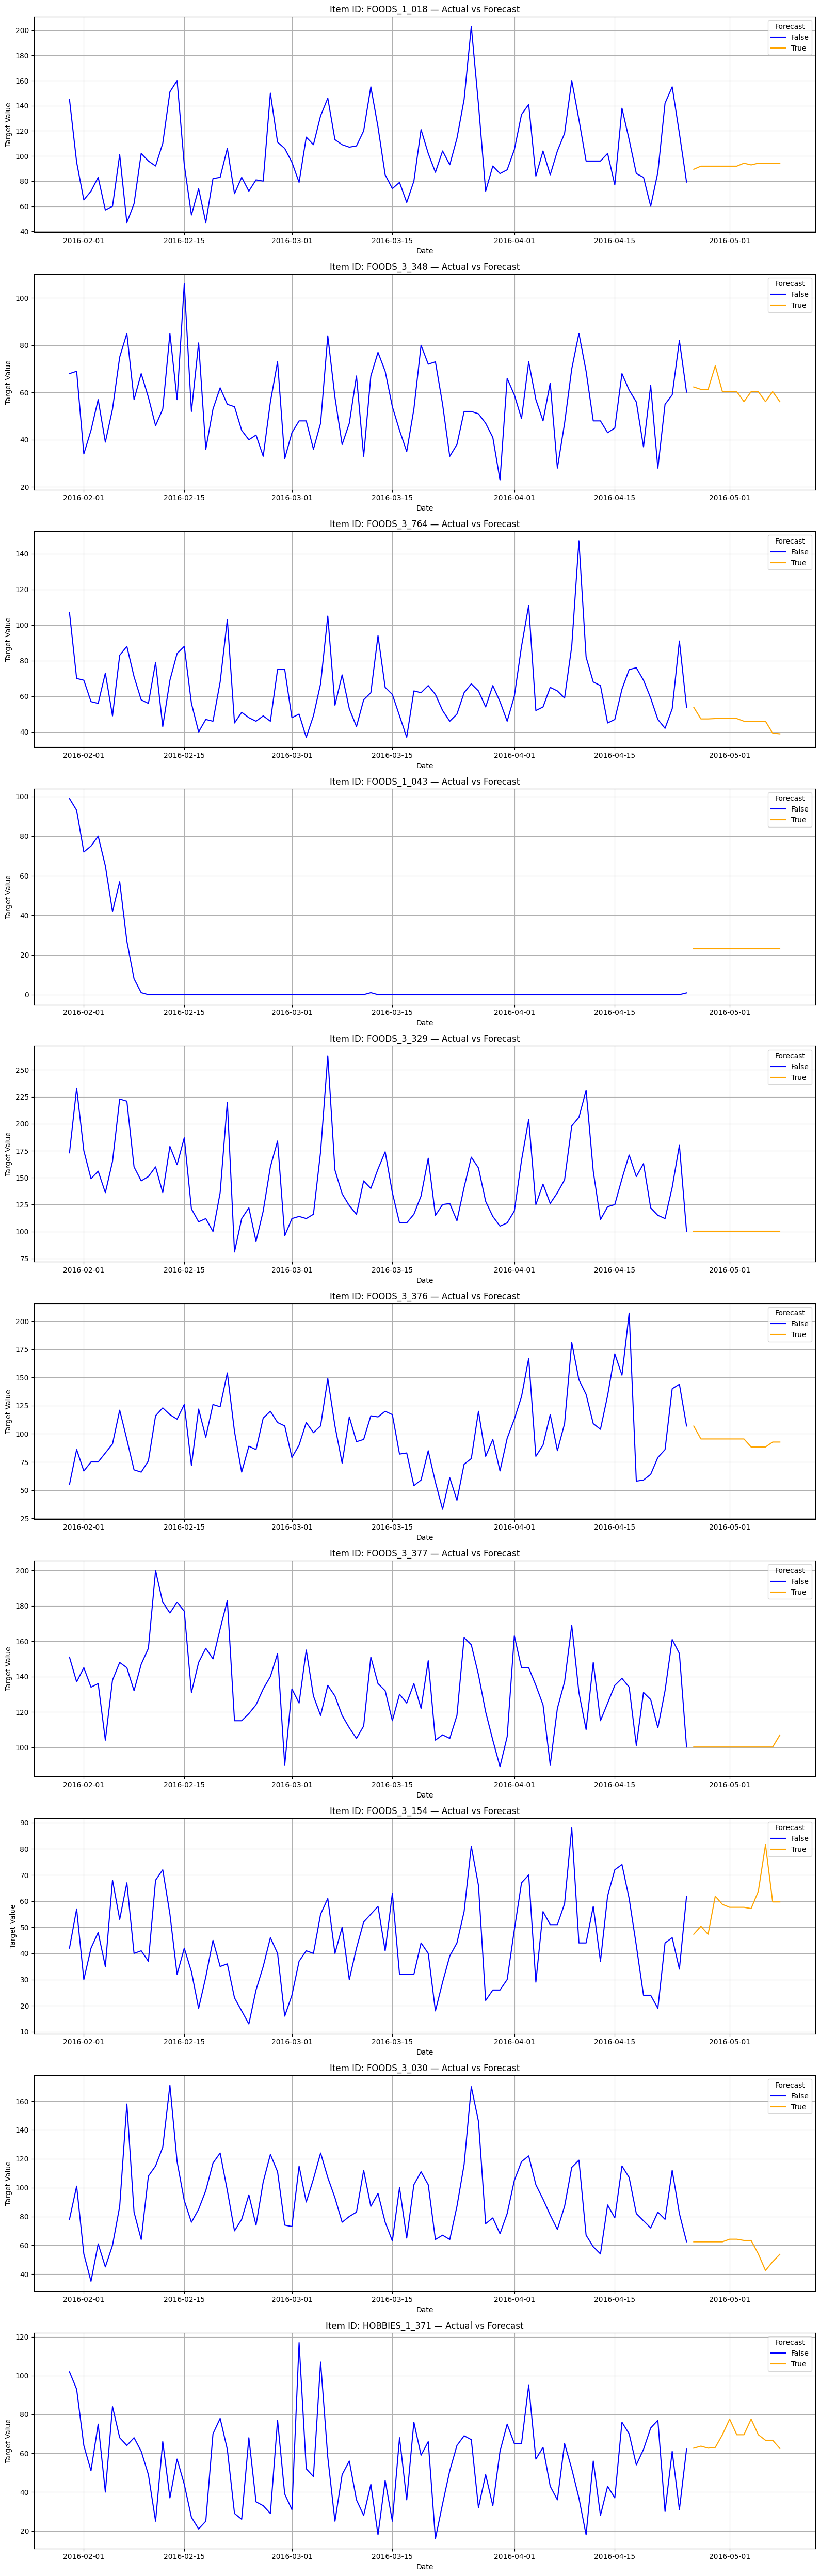

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure date is datetime
input_and_output_container["date"] = pd.to_datetime(input_and_output_container["date"])
forecast_start = forecast_horizon[0]

# Get items to visualize
items_to_plot = ids_to_predict
n_plot = len(items_to_plot )

# Plot
plt.figure(figsize=(16, 5 * n_plot))

for i, item in enumerate(items_to_plot, 1):
    df_item = input_and_output_container[input_and_output_container["item_id"] == item].iloc[-100:].copy()
    df_item["is_forecast"] = df_item["date"] > forecast_start

    plt.subplot(n_plot, 1, i)
    sns.lineplot(data=df_item, x="date", y="target", hue="is_forecast", palette={False: "blue", True: "orange"})
    plt.title(f"Item ID: {item} — Actual vs Forecast")
    plt.xlabel("Date")
    plt.ylabel("Target Value")
    plt.legend(title="Forecast")
    plt.grid(True)

plt.tight_layout()
plt.show()
